In [1]:
!python -V

Python 3.9.25


In [2]:
import pandas as pd

In [3]:
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [22]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location=('/home/administrator/mlops-zoomcamp/01-introduction + '
 '02-experiment_tracking/mlruns/1'), creation_time=1770737721732, experiment_id='1', last_update_time=1770737721732, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [5]:
df = pd.read_parquet('/home/administrator/dataset/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829623

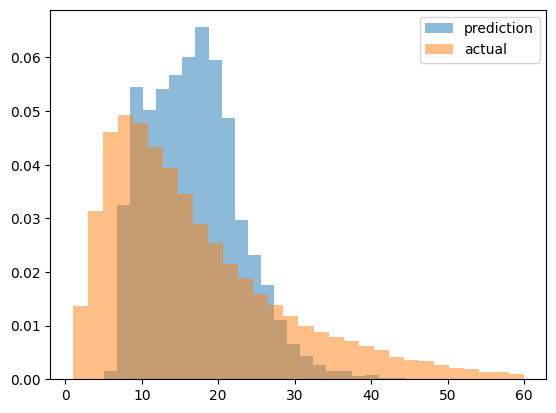

In [7]:
plt.hist(y_pred, bins=30, alpha=0.5, label='prediction', density=True)
plt.hist(y_train, bins=30, alpha=0.5, label='actual', density=True)
plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('/home/administrator/dataset/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/administrator/dataset/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871521021275

In [15]:
with open('/home/administrator/mlops-zoomcamp/01-introduction + 02-experiment_tracking/model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():
    mlflow.set_tag("model", "Lasso")
    mlflow.log_param("train-data-path", "/home/administrator/dataset/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "/home/administrator/dataset/green_tripdata_2021-02.parquet")
    alpha = 0.01
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [17]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:19:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74783                           
[1]	validation-rmse:6.91825                           
[2]	validation-rmse:6.74770                           
[3]	validation-rmse:6.70767                           
[4]	validation-rmse:6.69239                           
[5]	validation-rmse:6.68293                           
[6]	validation-rmse:6.68234                           
[7]	validation-rmse:6.67878                           
[8]	validation-rmse:6.67561                           
[9]	validation-rmse:6.67188                           
[10]	validation-rmse:6.66685                          
[11]	validation-rmse:6.65957                          
[12]	validation-rmse:6.65336                          
[13]	validation-rmse:6.64980                          
[14]	validation-rmse:6.64447                          
[15]	validation-rmse:6.64044                          
[16]	validation-rmse:6.63583                          
[17]	validation-rmse:6.62798                          
[18]	valid

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:19:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.73887                                                    
[1]	validation-rmse:6.64982                                                    
[2]	validation-rmse:6.63103                                                    
[3]	validation-rmse:6.61730                                                    
[4]	validation-rmse:6.60378                                                    
[5]	validation-rmse:6.59069                                                    
[6]	validation-rmse:6.58748                                                    
[7]	validation-rmse:6.57430                                                    
[8]	validation-rmse:6.57195                                                    
[9]	validation-rmse:6.56738                                                    
[10]	validation-rmse:6.56384                                                   
[11]	validation-rmse:6.56000                                                   
[12]	validation-rmse:6.55531            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:20:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.95980                                                    
[1]	validation-rmse:6.75232                                                    
[2]	validation-rmse:6.73231                                                    
[3]	validation-rmse:6.72799                                                    
[4]	validation-rmse:6.72469                                                    
[5]	validation-rmse:6.71541                                                    
[6]	validation-rmse:6.71391                                                    
[7]	validation-rmse:6.71331                                                    
[8]	validation-rmse:6.71019                                                    
[9]	validation-rmse:6.70426                                                    
[10]	validation-rmse:6.70064                                                   
[11]	validation-rmse:6.69783                                                   
[12]	validation-rmse:6.69057            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:20:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.97414                                                    
[1]	validation-rmse:7.01051                                                    
[2]	validation-rmse:6.79069                                                    
[3]	validation-rmse:6.73415                                                    
[4]	validation-rmse:6.71146                                                    
[5]	validation-rmse:6.70560                                                    
[6]	validation-rmse:6.69291                                                    
[7]	validation-rmse:6.69048                                                    
[8]	validation-rmse:6.68628                                                    
[9]	validation-rmse:6.68472                                                    
[10]	validation-rmse:6.68203                                                   
[11]	validation-rmse:6.67374                                                   
[12]	validation-rmse:6.66924            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:21:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.20707                                                    
[1]	validation-rmse:7.77147                                                    
[2]	validation-rmse:7.13511                                                    
[3]	validation-rmse:6.84886                                                    
[4]	validation-rmse:6.70938                                                    
[5]	validation-rmse:6.64334                                                    
[6]	validation-rmse:6.60104                                                    
[7]	validation-rmse:6.57559                                                    
[8]	validation-rmse:6.55854                                                    
[9]	validation-rmse:6.54111                                                    
[10]	validation-rmse:6.53250                                                   
[11]	validation-rmse:6.52363                                                   
[12]	validation-rmse:6.51908            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:22:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43031                                                   
[1]	validation-rmse:10.74732                                                   
[2]	validation-rmse:10.15389                                                   
[3]	validation-rmse:9.63976                                                    
[4]	validation-rmse:9.19684                                                    
[5]	validation-rmse:8.81572                                                    
[6]	validation-rmse:8.49025                                                    
[7]	validation-rmse:8.21165                                                    
[8]	validation-rmse:7.97490                                                    
[9]	validation-rmse:7.77389                                                    
[10]	validation-rmse:7.60293                                                   
[11]	validation-rmse:7.45881                                                   
[12]	validation-rmse:7.33637            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:24:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47921                                                    
[1]	validation-rmse:6.80011                                                    
[2]	validation-rmse:6.67621                                                    
[3]	validation-rmse:6.64553                                                    
[4]	validation-rmse:6.62915                                                    
[5]	validation-rmse:6.61675                                                    
[6]	validation-rmse:6.61276                                                    
[7]	validation-rmse:6.61109                                                    
[8]	validation-rmse:6.60450                                                    
[9]	validation-rmse:6.59375                                                    
[10]	validation-rmse:6.58305                                                   
[11]	validation-rmse:6.58429                                                   
[12]	validation-rmse:6.57962            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:24:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.14720                                                    
[1]	validation-rmse:7.10380                                                    
[2]	validation-rmse:6.84413                                                    
[3]	validation-rmse:6.75739                                                    
[4]	validation-rmse:6.72029                                                    
[5]	validation-rmse:6.69570                                                    
[6]	validation-rmse:6.68591                                                    
[7]	validation-rmse:6.68203                                                    
[8]	validation-rmse:6.68012                                                    
[9]	validation-rmse:6.67942                                                    
[10]	validation-rmse:6.67806                                                   
[11]	validation-rmse:6.67492                                                   
[12]	validation-rmse:6.67295            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:25:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.00867                                                   
[1]	validation-rmse:8.64140                                                    
[2]	validation-rmse:7.82304                                                    
[3]	validation-rmse:7.34869                                                    
[4]	validation-rmse:7.07238                                                    
[5]	validation-rmse:6.90966                                                    
[6]	validation-rmse:6.80714                                                    
[7]	validation-rmse:6.74359                                                    
[8]	validation-rmse:6.70602                                                    
[9]	validation-rmse:6.68250                                                    
[10]	validation-rmse:6.66350                                                   
[11]	validation-rmse:6.65163                                                   
[12]	validation-rmse:6.64337            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:26:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70309                                                   
[1]	validation-rmse:11.23512                                                   
[2]	validation-rmse:10.80652                                                   
[3]	validation-rmse:10.41444                                                   
[4]	validation-rmse:10.05642                                                   
[5]	validation-rmse:9.72989                                                    
[6]	validation-rmse:9.43280                                                    
[7]	validation-rmse:9.16250                                                    
[8]	validation-rmse:8.91705                                                    
[9]	validation-rmse:8.69505                                                    
[10]	validation-rmse:8.49354                                                   
[11]	validation-rmse:8.31171                                                   
[12]	validation-rmse:8.14739            

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:28:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.96687                                                     
[1]	validation-rmse:8.58396                                                     
[2]	validation-rmse:7.76471                                                     
[3]	validation-rmse:7.29415                                                     
[4]	validation-rmse:7.02396                                                     
[5]	validation-rmse:6.86518                                                     
[6]	validation-rmse:6.76813                                                     
[7]	validation-rmse:6.70800                                                     
[8]	validation-rmse:6.67051                                                     
[9]	validation-rmse:6.64683                                                     
[10]	validation-rmse:6.62881                                                    
[11]	validation-rmse:6.61641                                                    
[12]	validation-rmse:6.60568

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:29:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39458                                                     
[1]	validation-rmse:7.94330                                                     
[2]	validation-rmse:7.23610                                                     
[3]	validation-rmse:6.89611                                                     
[4]	validation-rmse:6.72997                                                     
[5]	validation-rmse:6.64136                                                     
[6]	validation-rmse:6.59074                                                     
[7]	validation-rmse:6.56067                                                     
[8]	validation-rmse:6.54136                                                     
[9]	validation-rmse:6.52922                                                     
[10]	validation-rmse:6.51984                                                    
[11]	validation-rmse:6.51447                                                    
[12]	validation-rmse:6.51073

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:29:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.08325                                                    
[1]	validation-rmse:8.72612                                                     
[2]	validation-rmse:7.87122                                                     
[3]	validation-rmse:7.35987                                                     
[4]	validation-rmse:7.05703                                                     
[5]	validation-rmse:6.87840                                                     
[6]	validation-rmse:6.75603                                                     
[7]	validation-rmse:6.69056                                                     
[8]	validation-rmse:6.63541                                                     
[9]	validation-rmse:6.60463                                                     
[10]	validation-rmse:6.58107                                                    
[11]	validation-rmse:6.56510                                                    
[12]	validation-rmse:6.55466

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:30:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.71527                                                     
[4]	validation-rmse:6.70601                                                     
[5]	validation-rmse:6.69993                                                     
[6]	validation-rmse:6.69648                                                     
[7]	validation-rmse:6.69047                                                     
[8]	validation-rmse:6.68303                                                     
[9]	validation-rmse:6.67592                                                     
[10]	validation-rmse:6.66832                                                    
[11]	validation-rmse:6.66219                                                    
[12]	validation-rmse:6.65795                                                    
[13]	validation-rmse:6.65306                                                    
[14]	validation-rmse:6.64872                                                    
[15]	validation-rmse:6.64643

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:30:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.99776                                                     
[1]	validation-rmse:6.92873                                                     
[2]	validation-rmse:6.66889                                                     
[3]	validation-rmse:6.59132                                                     
[4]	validation-rmse:6.55867                                                     
[5]	validation-rmse:6.54308                                                     
[6]	validation-rmse:6.53545                                                     
[7]	validation-rmse:6.52616                                                     
[8]	validation-rmse:6.51922                                                     
[9]	validation-rmse:6.50954                                                     
[10]	validation-rmse:6.50629                                                    
[11]	validation-rmse:6.50419                                                    
[12]	validation-rmse:6.49902

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:31:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.82594                                                     
[6]	validation-rmse:6.81884                                                     
[7]	validation-rmse:6.80964                                                     
[8]	validation-rmse:6.80523                                                     
[9]	validation-rmse:6.80282                                                     
[10]	validation-rmse:6.79740                                                    
[11]	validation-rmse:6.79475                                                    
[12]	validation-rmse:6.79180                                                    
[13]	validation-rmse:6.78748                                                    
[14]	validation-rmse:6.78603                                                    
[15]	validation-rmse:6.78102                                                    
[16]	validation-rmse:6.77924                                                    
[17]	validation-rmse:6.77702

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:31:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.39135                                                    
[1]	validation-rmse:9.13500                                                     
[2]	validation-rmse:8.29216                                                     
[3]	validation-rmse:7.73910                                                     
[4]	validation-rmse:7.37816                                                     
[5]	validation-rmse:7.14501                                                     
[6]	validation-rmse:6.99502                                                     
[7]	validation-rmse:6.89809                                                     
[8]	validation-rmse:6.82769                                                     
[9]	validation-rmse:6.78013                                                     
[10]	validation-rmse:6.74697                                                    
[11]	validation-rmse:6.72216                                                    
[12]	validation-rmse:6.70496

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:32:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.84867                                                     
[1]	validation-rmse:6.87811                                                     
[2]	validation-rmse:6.66466                                                     
[3]	validation-rmse:6.60252                                                     
[4]	validation-rmse:6.57486                                                     
[5]	validation-rmse:6.55813                                                     
[6]	validation-rmse:6.55204                                                     
[7]	validation-rmse:6.54504                                                     
[8]	validation-rmse:6.54093                                                     
[9]	validation-rmse:6.53160                                                     
[10]	validation-rmse:6.52714                                                    
[11]	validation-rmse:6.52216                                                    
[12]	validation-rmse:6.51457

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:33:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28355                                                    
[1]	validation-rmse:10.48986                                                    
[2]	validation-rmse:9.81850                                                     
[3]	validation-rmse:9.25026                                                     
[4]	validation-rmse:8.77352                                                     
[5]	validation-rmse:8.37457                                                     
[6]	validation-rmse:8.04152                                                     
[7]	validation-rmse:7.76644                                                     
[8]	validation-rmse:7.53928                                                     
[9]	validation-rmse:7.34989                                                     
[10]	validation-rmse:7.19614                                                    
[11]	validation-rmse:7.06960                                                    
[12]	validation-rmse:6.96546

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:34:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.54606                                                     
[1]	validation-rmse:8.12671                                                     
[2]	validation-rmse:7.41456                                                     
[3]	validation-rmse:7.06166                                                     
[4]	validation-rmse:6.88750                                                     
[5]	validation-rmse:6.79185                                                     
[6]	validation-rmse:6.73988                                                     
[7]	validation-rmse:6.70743                                                     
[8]	validation-rmse:6.68282                                                     
[9]	validation-rmse:6.66884                                                     
[10]	validation-rmse:6.65389                                                    
[11]	validation-rmse:6.64669                                                    
[12]	validation-rmse:6.64114

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:35:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00885                                                    
[1]	validation-rmse:10.03570                                                    
[2]	validation-rmse:9.25354                                                     
[3]	validation-rmse:8.63529                                                     
[4]	validation-rmse:8.14945                                                     
[5]	validation-rmse:7.76889                                                     
[6]	validation-rmse:7.47335                                                     
[7]	validation-rmse:7.24445                                                     
[8]	validation-rmse:7.06909                                                     
[9]	validation-rmse:6.93091                                                     
[10]	validation-rmse:6.82754                                                    
[11]	validation-rmse:6.74292                                                    
[12]	validation-rmse:6.68111

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:36:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03618                                                    
[1]	validation-rmse:10.07859                                                    
[2]	validation-rmse:9.30952                                                     
[3]	validation-rmse:8.69205                                                     
[4]	validation-rmse:8.20638                                                     
[5]	validation-rmse:7.82193                                                     
[6]	validation-rmse:7.51967                                                     
[7]	validation-rmse:7.28872                                                     
[8]	validation-rmse:7.10723                                                     
[9]	validation-rmse:6.96562                                                     
[10]	validation-rmse:6.85600                                                    
[11]	validation-rmse:6.77008                                                    
[12]	validation-rmse:6.70240

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:38:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01604                                                    
[1]	validation-rmse:10.04587                                                    
[2]	validation-rmse:9.27089                                                     
[3]	validation-rmse:8.65073                                                     
[4]	validation-rmse:8.16452                                                     
[5]	validation-rmse:7.78238                                                     
[6]	validation-rmse:7.48685                                                     
[7]	validation-rmse:7.25897                                                     
[8]	validation-rmse:7.07975                                                     
[9]	validation-rmse:6.94505                                                     
[10]	validation-rmse:6.83852                                                    
[11]	validation-rmse:6.75409                                                    
[12]	validation-rmse:6.68987

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:39:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71685                                                    
[1]	validation-rmse:11.25942                                                    
[2]	validation-rmse:10.83817                                                    
[3]	validation-rmse:10.45161                                                    
[4]	validation-rmse:10.09682                                                    
[5]	validation-rmse:9.77183                                                     
[6]	validation-rmse:9.47448                                                     
[7]	validation-rmse:9.20198                                                     
[8]	validation-rmse:8.95365                                                     
[9]	validation-rmse:8.72713                                                     
[10]	validation-rmse:8.52092                                                    
[11]	validation-rmse:8.33368                                                    
[12]	validation-rmse:8.16311

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:41:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90873                                                    
[1]	validation-rmse:9.87429                                                     
[2]	validation-rmse:9.06734                                                     
[3]	validation-rmse:8.43957                                                     
[4]	validation-rmse:7.95903                                                     
[5]	validation-rmse:7.59220                                                     
[6]	validation-rmse:7.31470                                                     
[7]	validation-rmse:7.10645                                                     
[8]	validation-rmse:6.95081                                                     
[9]	validation-rmse:6.83279                                                     
[10]	validation-rmse:6.74257                                                    
[11]	validation-rmse:6.67338                                                    
[12]	validation-rmse:6.62183

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:42:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50881                                                    
[1]	validation-rmse:10.88575                                                    
[2]	validation-rmse:10.33784                                                    
[3]	validation-rmse:9.85286                                                     
[4]	validation-rmse:9.43005                                                     
[5]	validation-rmse:9.05582                                                     
[6]	validation-rmse:8.73159                                                     
[7]	validation-rmse:8.44043                                                     
[8]	validation-rmse:8.19988                                                     
[9]	validation-rmse:7.98599                                                     
[10]	validation-rmse:7.79402                                                    
[11]	validation-rmse:7.63433                                                    
[12]	validation-rmse:7.49277

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:45:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.29361                                                     
[1]	validation-rmse:10.51071                                                     
[2]	validation-rmse:9.84508                                                      
[3]	validation-rmse:9.28488                                                      
[4]	validation-rmse:8.81157                                                      
[5]	validation-rmse:8.41754                                                      
[6]	validation-rmse:8.09131                                                      
[7]	validation-rmse:7.81689                                                      
[8]	validation-rmse:7.59315                                                      
[9]	validation-rmse:7.40891                                                      
[10]	validation-rmse:7.25420                                                     
[11]	validation-rmse:7.12988                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:47:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.77728                                                     
[1]	validation-rmse:9.67765                                                      
[2]	validation-rmse:8.84722                                                      
[3]	validation-rmse:8.22788                                                      
[4]	validation-rmse:7.77121                                                      
[5]	validation-rmse:7.43761                                                      
[6]	validation-rmse:7.19561                                                      
[7]	validation-rmse:7.02018                                                      
[8]	validation-rmse:6.89071                                                      
[9]	validation-rmse:6.79768                                                      
[10]	validation-rmse:6.72772                                                     
[11]	validation-rmse:6.67284                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:48:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59036                                                    
[1]	validation-rmse:11.03263                                                    
[2]	validation-rmse:10.52926                                                    
[3]	validation-rmse:10.08235                                                    
[4]	validation-rmse:9.68162                                                     
[5]	validation-rmse:9.32287                                                     
[6]	validation-rmse:9.00665                                                     
[7]	validation-rmse:8.72591                                                     
[8]	validation-rmse:8.47177                                                     
[9]	validation-rmse:8.25192                                                     
[10]	validation-rmse:8.05907                                                    
[11]	validation-rmse:7.88717                                                    
[12]	validation-rmse:7.73654

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:50:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79270                                                     
[1]	validation-rmse:11.39992                                                     
[2]	validation-rmse:11.03355                                                     
[3]	validation-rmse:10.69241                                                     
[4]	validation-rmse:10.37533                                                     
[5]	validation-rmse:10.07969                                                     
[6]	validation-rmse:9.80516                                                      
[7]	validation-rmse:9.54993                                                      
[8]	validation-rmse:9.31385                                                      
[9]	validation-rmse:9.09421                                                      
[10]	validation-rmse:8.89024                                                     
[11]	validation-rmse:8.70310                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:53:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79763                                                     
[1]	validation-rmse:11.40948                                                     
[2]	validation-rmse:11.04668                                                     
[3]	validation-rmse:10.70817                                                     
[4]	validation-rmse:10.39297                                                     
[5]	validation-rmse:10.09904                                                     
[6]	validation-rmse:9.82576                                                      
[7]	validation-rmse:9.57181                                                      
[8]	validation-rmse:9.33594                                                      
[9]	validation-rmse:9.11668                                                      
[10]	validation-rmse:8.91470                                                     
[11]	validation-rmse:8.72615                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:56:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79135                                                     
[1]	validation-rmse:11.39788                                                     
[2]	validation-rmse:11.03123                                                     
[3]	validation-rmse:10.68979                                                     
[4]	validation-rmse:10.37210                                                     
[5]	validation-rmse:10.07692                                                     
[6]	validation-rmse:9.80277                                                      
[7]	validation-rmse:9.54851                                                      
[8]	validation-rmse:9.31316                                                      
[9]	validation-rmse:9.09499                                                      
[10]	validation-rmse:8.89330                                                     
[11]	validation-rmse:8.70730                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:59:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28848                                                     
[1]	validation-rmse:10.50044                                                     
[2]	validation-rmse:9.83156                                                      
[3]	validation-rmse:9.26866                                                      
[4]	validation-rmse:8.79409                                                      
[5]	validation-rmse:8.39896                                                      
[6]	validation-rmse:8.07035                                                      
[7]	validation-rmse:7.79815                                                      
[8]	validation-rmse:7.57355                                                      
[9]	validation-rmse:7.38801                                                      
[10]	validation-rmse:7.23600                                                     
[11]	validation-rmse:7.11098                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:01:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65437                                                     
[1]	validation-rmse:11.14543                                                     
[2]	validation-rmse:10.68224                                                     
[3]	validation-rmse:10.26238                                                     
[4]	validation-rmse:9.88138                                                      
[5]	validation-rmse:9.53701                                                      
[6]	validation-rmse:9.22560                                                      
[7]	validation-rmse:8.94506                                                      
[8]	validation-rmse:8.69167                                                      
[9]	validation-rmse:8.46579                                                      
[10]	validation-rmse:8.26146                                                     
[11]	validation-rmse:8.07874                                                     
[12]	validation-

/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:03:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33872                                                     
[1]	validation-rmse:10.58760                                                     
[2]	validation-rmse:9.94499                                                      
[3]	validation-rmse:9.39865                                                      
[4]	validation-rmse:8.93580                                                      
[5]	validation-rmse:8.54542                                                      
[6]	validation-rmse:8.21765                                                      
[7]	validation-rmse:7.94387                                                      
[8]	validation-rmse:7.71413                                                      
[9]	validation-rmse:7.52486                                                      
[10]	validation-rmse:7.36615                                                     
[11]	validation-rmse:7.23469                                                     
[12]	validation-

KeyboardInterrupt: 

In [24]:
params = {
    'learning_rate': 0.88339340151814,
    'max_depth': 4,
    'min_child_weight': 19.522579282111053,
    'objective': 'reg:linear',
    'reg_alpha': 0.07625395721554082,
    'reg_lambda': 0.02984085122278691,
    'seed': 42
}

mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2026/02/12 03:21:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6c3cf5fd5f5a48aaa4eed32d90d2978e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:7.10262


/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:21:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:6.88990
[2]	validation-rmse:6.87420
[3]	validation-rmse:6.86465
[4]	validation-rmse:6.85772
[5]	validation-rmse:6.82594
[6]	validation-rmse:6.81884
[7]	validation-rmse:6.80964
[8]	validation-rmse:6.80523
[9]	validation-rmse:6.80282
[10]	validation-rmse:6.79740
[11]	validation-rmse:6.79475
[12]	validation-rmse:6.79180
[13]	validation-rmse:6.78748
[14]	validation-rmse:6.78603
[15]	validation-rmse:6.78102
[16]	validation-rmse:6.77924
[17]	validation-rmse:6.77702
[18]	validation-rmse:6.77338
[19]	validation-rmse:6.76315
[20]	validation-rmse:6.76245
[21]	validation-rmse:6.76004
[22]	validation-rmse:6.75981
[23]	validation-rmse:6.75711
[24]	validation-rmse:6.75118
[25]	validation-rmse:6.74849
[26]	validation-rmse:6.74839
[27]	validation-rmse:6.74765
[28]	validation-rmse:6.74561
[29]	validation-rmse:6.73290
[30]	validation-rmse:6.73159
[31]	validation-rmse:6.72995
[32]	validation-rmse:6.72333
[33]	validation-rmse:6.72309
[34]	validation-rmse:6.72135
[35]	validation-rmse:6.

2026/02/12 03:22:34 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/02/12 03:22:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/12 03:22:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/administrator/anaconda3/envs/experiment_tracking/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:22:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2026/02/12 03:22:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
